In [184]:
import argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('image', cmap='gray')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

In [10]:
path_outputs = '../data/hw03_outputs/'

In [31]:
divisions = np.array([1., 2., 4., 8., 16.])
n_epoch = 10

In [5]:
%run main.py --training-division 1 --epochs 10 --name best_conv_div_1 --save-model
%run main.py --training-division 2 --epochs 10 --name best_conv_div_2 --save-model
%run main.py --training-division 4 --epochs 10 --name best_conv_div_4 --save-model
%run main.py --training-division 8 --epochs 10 --name best_conv_div_8 --save-model
%run main.py --training-division 16 --epochs 10 --name best_conv_div_16 --save-model

Train Epoch: 1 [11144/60000 (100%)]	Loss: 1.224288
Training set: Average loss: 0.7314, Accuracy: 40353.0/51000 (79%)
Validation set: Average loss: 0.5303, Accuracy: 7784.0/9000 (86%)

Train Epoch: 2 [11144/60000 (100%)]	Loss: 0.891458
Training set: Average loss: 0.3668, Accuracy: 46000.0/51000 (90%)
Validation set: Average loss: 0.2516, Accuracy: 8471.0/9000 (94%)

Train Epoch: 3 [11144/60000 (100%)]	Loss: 0.941411
Training set: Average loss: 0.2674, Accuracy: 47247.0/51000 (93%)
Validation set: Average loss: 0.1778, Accuracy: 8589.0/9000 (95%)

Train Epoch: 4 [11144/60000 (100%)]	Loss: 0.470888
Training set: Average loss: 0.2159, Accuracy: 47977.0/51000 (94%)
Validation set: Average loss: 0.1454, Accuracy: 8679.0/9000 (96%)

Train Epoch: 5 [11144/60000 (100%)]	Loss: 0.375562
Training set: Average loss: 0.1881, Accuracy: 48288.0/51000 (95%)
Validation set: Average loss: 0.1290, Accuracy: 8723.0/9000 (97%)

Train Epoch: 6 [11144/60000 (100%)]	Loss: 0.822806
Training set: Average loss: 0

In [68]:
%run main.py --name best_conv_div_1 --evaluate
%run main.py --name best_conv_div_2 --evaluate
%run main.py --name best_conv_div_4 --evaluate
%run main.py --name best_conv_div_8 --evaluate
%run main.py --name best_conv_div_16 --evaluate

Test set: Average loss: 0.0803, Accuracy: 9771.0/10000 (98%)
Test set: Average loss: 0.0991, Accuracy: 9704.0/10000 (97%)
Test set: Average loss: 0.1722, Accuracy: 9596.0/10000 (96%)
Test set: Average loss: 0.3732, Accuracy: 8972.0/10000 (90%)
Test set: Average loss: 0.9375, Accuracy: 7061.0/10000 (71%)


In [23]:
train_accuracies = [np.load(path_outputs+f'best_conv_div_{d}_train_accuracy.npy') for d in divisions]
test_accuracies = [np.load(path_outputs+f'best_conv_div_{d}_test_accuracy.npy') for d in divisions]
train_accuracies = np.vstack(tuple(train_accuracies))
test_accuracies = np.vstack(tuple(test_accuracies))

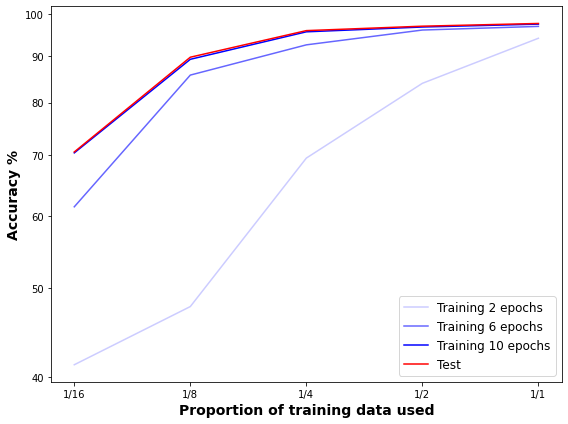

In [53]:
fig = plt.figure(figsize=(8, 6), tight_layout=True)
ax = plt.axes()
ax.loglog(1/divisions, train_accuracies[:, 1], color=(.8, .8, 1), label='Training 2 epochs')
ax.loglog(1/divisions, train_accuracies[:, 5], color=(.4, .4, 1), label='Training 6 epochs')
ax.loglog(1/divisions, train_accuracies[:, 9], color=(0, 0, 1), label='Training 10 epochs')
ax.loglog(1/divisions, test_accuracies, 'r-', label='Test')
ax.set_xticks(1/divisions)
ax.set_xticklabels([f'1/{d:.0f}' for d in divisions])
ax.set_xticks([], minor=True)
ax.set_yticks(range(40, 110, 10))
ax.set_yticklabels(range(40, 110, 10))
ax.set_xlabel('Proportion of training data used', fontsize=14, fontweight='bold')
ax.set_ylabel('Accuracy %', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)
plt.savefig(path_outputs+'divisions.pdf', pad_inches=0, bbox_inches='tight')
plt.show()

In [138]:
test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1000, shuffle=False, num_workers=1, pin_memory=True)

test_labels = np.array([data[1] for data in test_dataset])
labels = np.unique(test_labels)
preds = np.load(path_outputs+'best_conv_div_1_preds.npy')
idc_wrong = np.argwhere(test_labels!=preds).flatten()

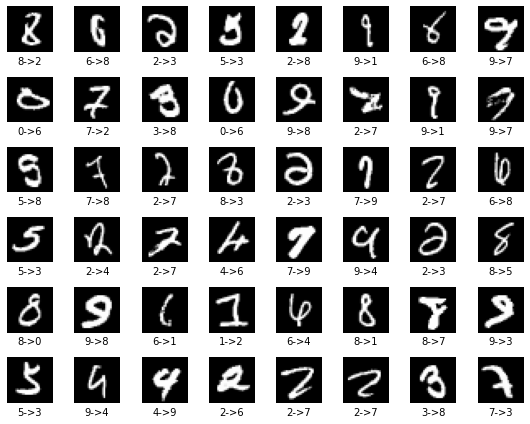

In [187]:
w, h = (8, 6)
rng = np.random.default_rng(2020)
idc = rng.choice(idc_wrong, (w*h,), replace=False)
fig = plt.figure(figsize=(w, h), tight_layout=True)
for k, idx in enumerate(idc):
    ax = plt.subplot(h, w, k+1)
    plt.imshow(test_dataset[idx][0].numpy().squeeze())
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel(f'{test_dataset[idx][1]}->{preds[idx]}')
plt.savefig(path_outputs+'mistakes.pdf', pad_inches=0, bbox_inches='tight')
plt.show()

In [103]:
state_dict = torch.load(os.path.join(path_outputs, 'best_conv.pt'))
kernels = state_dict['conv1.weight'].cpu().numpy().squeeze()

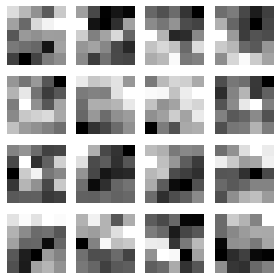

In [105]:
w, h = (4, 4)
fig = plt.figure(figsize=(w, h), tight_layout=True)
for k in range(w*h):
    ax = plt.subplot(h, w, k+1)
    plt.imshow(kernels[k, :, :])
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
plt.savefig(path_outputs+'kernels.pdf', pad_inches=0, bbox_inches='tight')
plt.show()

In [118]:
confusion = np.zeros((10, 10))
for k in range(len(preds)):
    confusion[test_labels[k], preds[k]] += 1
confusion_norm = confusion/confusion.sum(axis=1)
confusion_norm_off = confusion_norm.copy()
for k in range(10):
    confusion_norm_off[k, k] = 0

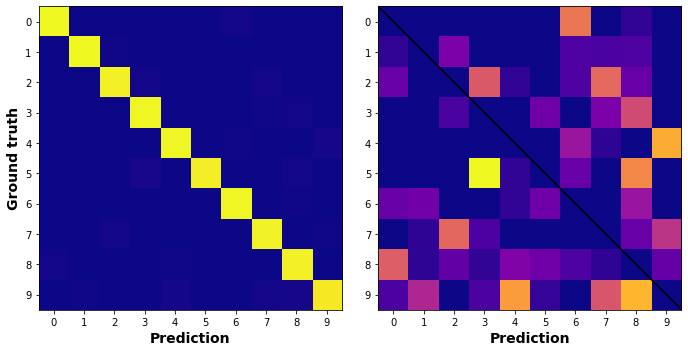

In [130]:
fig = plt.figure(figsize=(10, 5), tight_layout=True)
plt.subplot(121)
plt.imshow(confusion_norm, cmap='plasma')
# plt.plot([-0.5, 9.5], [-0.5, 9.5], 'k-')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Prediction', fontsize=14, fontweight='bold')
plt.ylabel('Ground truth', fontsize=14, fontweight='bold')
plt.subplot(122)
plt.imshow(confusion_norm_off, cmap='plasma')
plt.plot([-0.5, 9.5], [-0.5, 9.5], 'k-')
plt.xticks(np.arange(10))
plt.yticks(np.arange(10))
plt.xlabel('Prediction', fontsize=14, fontweight='bold')
# plt.ylabel('Ground truth', fontsize=14, fontweight='bold')
plt.savefig(path_outputs+'confusions.pdf', pad_inches=0, bbox_inches='tight')
plt.show()

In [131]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(16, 24, kernel_size=3, stride=1, padding=1, padding_mode='replicate')
        self.batchNorm1 = nn.BatchNorm2d(16)
        self.batchNorm2 = nn.BatchNorm2d(24)
        self.dropout2d1 = nn.Dropout2d(0.6)
        self.dropout2d2 = nn.Dropout2d(0.6)
        self.fc1 = nn.Linear(1176, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        self.dropout1 = nn.Dropout(0.9)
        self.dropout2 = nn.Dropout(0.8)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d1(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        output = F.log_softmax(x, dim=1)
        return output

    def forward_fc2(self, x):
        x = self.conv1(x)
        x = self.batchNorm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d1(x)

        x = self.conv2(x)
        x = self.batchNorm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2d2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.dropout1(x)
        x = self.fc2(x)
        x = F.relu(x)
        
        return x
    

In [132]:
device = torch.device("cuda")
model = Net().to(device)
model.load_state_dict(torch.load(os.path.join(path_outputs, 'best_conv.pt')))

<All keys matched successfully>

In [163]:
def vectorize(model, device, test_loader):
    output = np.zeros((0, 64))
    model.eval()    # Set the model to inference mode
    with torch.no_grad():   # For the inference step, gradient is not computed
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            fc2 = model.forward_fc2(data).cpu().numpy()
            output = np.vstack((output, fc2))
    
    return output


In [164]:
vectors = vectorize(model, device, test_loader)

In [165]:
vectors.shape

(10000, 64)

In [180]:
embedded = TSNE(n_components=2, perplexity=100, n_jobs=-1).fit_transform(vectors)

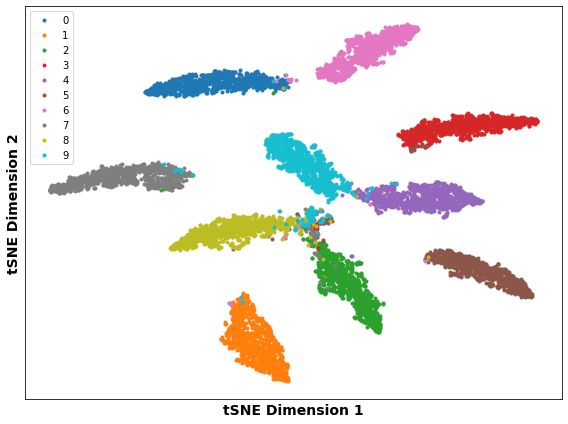

In [183]:
plt.figure(figsize=(8, 6), tight_layout=True)
for k in range(10):
    plt.plot(embedded[test_labels==k, 0], embedded[test_labels==k, 1], '.', label=k)
plt.legend()
plt.xlabel('tSNE Dimension 1', fontsize=14, fontweight='bold')
plt.ylabel('tSNE Dimension 2', fontsize=14, fontweight='bold')
plt.xticks([])
plt.yticks([])
plt.savefig(path_outputs+'tsne.pdf', pad_inches=0, bbox_inches='tight')
plt.show()

In [186]:
distance = euclidean_distances(vectors, vectors)
distance.shape

(10000, 10000)

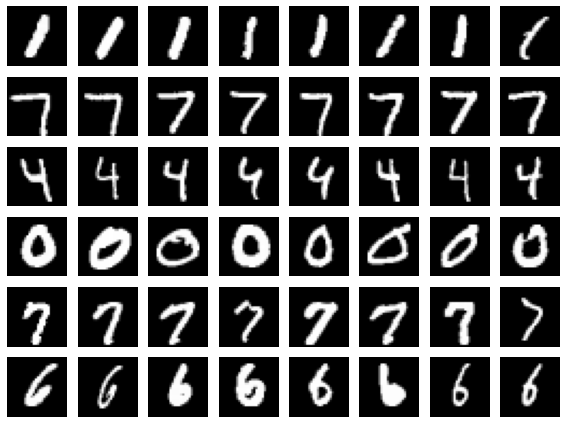

In [197]:
w, h = (8, 6)
idc = np.zeros((h, w), dtype=int)
idc[:, 0] = rng.choice(10000, (h,), replace=False)
for k in range(h):
    idc[k, 1:w] = np.argsort(distance[idc[k, 0]])[1:w]

fig = plt.figure(figsize=(w, h), tight_layout=True)
for k, idx in enumerate(idc.flatten()):
    ax = plt.subplot(h, w, k+1)
    plt.imshow(test_dataset[idx][0].numpy().squeeze())
    plt.box(False)
    plt.xticks([])
    plt.yticks([])
#     ax.set_xlabel(f'{test_dataset[idx][1]}->{preds[idx]}')
plt.savefig(path_outputs+'close.pdf', pad_inches=0, bbox_inches='tight')
plt.show()